# Plots speed transects

In [1]:
# datasets/analysis
import numpy as np
import xarray as xr
import gsw

# cosima
import cosima_cookbook as cc

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35383/status,
Dashboard: /proxy/35383/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44677,Workers: 7
Dashboard: /proxy/35383/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:32807,Total threads: 4
Dashboard: /proxy/37261/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38657,


In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [5]:
# database for ssp585_wind_thermal simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

Define function to read in speed. 

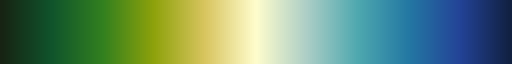

In [6]:
def read_data(start_time, end_time, expt, session, lon):
    lat_slice  = slice(-90,-59)
    z_slice = slice(0,6000)
    time_slice = slice(start_time, end_time)
    
    uvel = cc.querying.getvar(expt,'u',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    vvel = cc.querying.getvar(expt,'v',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    temp = cc.querying.getvar(expt,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)-273.15
    salt = cc.querying.getvar(expt,'salt',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    
    uvel = uvel.sel(yu_ocean=lat_slice).sel(st_ocean=z_slice).sel(xu_ocean=lon, method='nearest')
    vvel = vvel.sel(yu_ocean=lat_slice).sel(st_ocean=z_slice).sel(xu_ocean=lon, method='nearest')
    temp = temp.sel(yt_ocean=lat_slice).sel(st_ocean=z_slice).sel(xt_ocean=lon, method='nearest')
    salt = salt.sel(yt_ocean=lat_slice).sel(st_ocean=z_slice).sel(xt_ocean=lon, method='nearest')

    # convert to absolute salinity
    p = gsw.conversions.p_from_z(-temp.st_ocean, temp.yt_ocean)
    SA = gsw.conversions.SA_from_SP(salt, p, lon,  salt.yt_ocean)
    
    # calculate density (sigma_0 and sigma_1)
    sigma_0 = gsw.density.sigma0(SA, temp)
    #sigma_1 = gsw.density.sigma1(SA, temp)

    # calculate speed
    spd = np.sqrt(uvel**2 + vvel**2)
    
    return spd.compute(), sigma_0.compute()

def colorbar_vert(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    #cbar.ax.tick_params(labelsize=fs, labeltop=True)
    return cbar

cmap_alpha = plt.cm.Greys_r
cmap_alpha.set_bad('w')
cmap_alpha.set_under('white')

from palettable.cmocean.diverging import Delta_11_r
cmap = plt.cm.get_cmap(Delta_11_r.mpl_colormap)
#levels = np.arange(-0.1, 0.1005, 0.005)
#levels = np.arange(-0.15, 0.1505, 0.01)
levels = np.arange(-0.2, 0.205, 0.01)
cmap.set_bad('k')
cmap

In [7]:
zonal_lons = [-242.15, -92.95,  -32.75,   65.25]
lon_labels = ['118\u00b0E [transect B]','93\u00b0W [transect D]','33\u00b0W [transect E]','65\u00b0E [transect F]']
lon_labels = ['118\u00b0E: transect B','93\u00b0W: transect D','33\u00b0W: transect E','65\u00b0E: transect F']
transect_labels = ['B','D','E','F']

transect = ['b', 'c', 'd', 'e', 'f']
lat_n_lim = [-64.06989798, -75.40631884, -70.54879308, -71.43581953, -65.98694281]
lat_630m = [-65.22663443, -75.9976698, -72.40732468, -76.4623027, -67.50755957]
lat_1000m = [-65.18439508, -75.95543044, -70.54879308, -74.22361691, -66.78949054]

In [8]:
expt = ssp245mw
start_time = '2160-01-01'
end_time = '2164-12-31'

# lvls = [32.3, 32.4, 32.45, 32.5, 32.55]
# lvls = [27.2, 27.4, 27.6, 27.8, 28.0]

Read in data and save to file for faster plotting. 

In [9]:
%%time
transects = ['b', 'd', 'e', 'f']

for index in range(4):
    print(f'{zonal_lons[index]}')
    spd_ctrl, sig0_ctrl = read_data(start_time, end_time, control, master_session, zonal_lons[index])
    spd_expt, sig0_expt = read_data(start_time, end_time, expt, expt_session, zonal_lons[index])

    # convert to dataset
    ds = spd_ctrl.to_dataset(name='spd_ctrl')
    ds['sig0_ctrl'] = sig0_ctrl
    ds['spd_expt'] = spd_expt
    ds['sig0_expt'] = sig0_expt
    ds.attrs['Transect longitude:'] = zonal_lons[index]

    # save to file
    outdir = f'/scratch/e14/hd4873/tmp/project3/fig10_speed_transect_{transects[index]}.nc'
    print(f'Saving to file: {outdir}')
    ds.to_netcdf(outdir)

-242.15
Saving to file: /scratch/e14/hd4873/tmp/project3/fig10_speed_transect_b.nc
-92.95
Saving to file: /scratch/e14/hd4873/tmp/project3/fig10_speed_transect_d.nc
-32.75
Saving to file: /scratch/e14/hd4873/tmp/project3/fig10_speed_transect_e.nc
65.25
Saving to file: /scratch/e14/hd4873/tmp/project3/fig10_speed_transect_f.nc
CPU times: user 3min 28s, sys: 27.8 s, total: 3min 56s
Wall time: 6min 2s


Define figure functions. 

In [15]:
def figure_setup():
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,9.5), height_ratios=[0.5, 0.7, 0.2, 0.5, 0.7])
    plt.subplots_adjust(hspace=0.05, wspace=0.14)

    for i, ax in enumerate(axes.flatten()):
        ax.set_facecolor('grey')
        
    axes[-1,0].set_xlabel('Latitude (\u00b0S)')
    axes[-1,1].set_xlabel('Latitude (\u00b0S)')

    fig.delaxes(axes[2,0])
    fig.delaxes(axes[2,1])

    # add sublot labels
    axes[1,0].text(0.02, 0.05, 'A',  c='k', fontsize=24, ha='left', fontweight='bold', transform=axes[1,0].transAxes)
    axes[1,1].text(0.02, 0.05, 'B',  c='k', fontsize=24, ha='left', fontweight='bold', transform=axes[1,1].transAxes)
    axes[4,0].text(0.02, 0.05, 'C',  c='k', fontsize=24, ha='left', fontweight='bold', transform=axes[4,0].transAxes)
    axes[4,1].text(0.02, 0.05, 'D',  c='k', fontsize=24, ha='left', fontweight='bold', transform=axes[4,1].transAxes)

    tc = '#45484d'
    axes[0,0].text(0.0, 1.06, f'{lon_labels[0]}', c=tc, fontsize=15, ha='left', fontweight='bold', transform=axes[0,0].transAxes)
    axes[0,1].text(0.0, 1.06, f'{lon_labels[1]}', c=tc, fontsize=15, ha='left', fontweight='bold', transform=axes[0,1].transAxes)
    axes[3,0].text(0.0, 1.06, f'{lon_labels[2]}', c=tc, fontsize=15, ha='left', fontweight='bold', transform=axes[3,0].transAxes)
    axes[3,1].text(0.0, 1.06, f'{lon_labels[3]}', c=tc, fontsize=15, ha='left', fontweight='bold', transform=axes[3,1].transAxes)

    axes[0,0].set_xticks([])
    axes[0,1].set_xticks([])
    axes[3,0].set_xticks([])
    axes[3,1].set_xticks([])

    return fig, axes


def plot_speed_anomaly(transect, lon, axes):
    
    # read in speed and density transect data
    ds = xr.open_dataset(f'/scratch/e14/hd4873/tmp/project3/fig10_speed_transect_{transect}.nc').load()
    spd_ctrl = ds['spd_ctrl']
    sig0_ctrl = ds['sig0_ctrl']
    spd_expt = ds['spd_expt']
    sig0_expt = ds['sig0_expt']
    
    # shade speed anomaly
    cb = axes[0].contourf(spd_ctrl.yu_ocean, spd_ctrl.st_ocean, spd_expt.mean('time') - spd_ctrl.mean('time'),
                          cmap=cmap, norm=mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False), 
                          levels=levels, extend='both')
    axes[1].contourf(spd_ctrl.yu_ocean, spd_ctrl.st_ocean, spd_expt.mean('time') - spd_ctrl.mean('time'),
                     cmap=cmap, norm=mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False), 
                     levels=levels, extend='both')
    
    axes[0].set_ylim([630, 0])
    axes[1].set_ylim([3000, 630])

    return ds, cb


def plot_density_contours(lvls, sigma, lon_indices, spacing, axes, experiment_name, lw):
    
    if experiment_name == 'control':
        cs = axes[0].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                             levels=lvls, colors='grey', linestyles='--', linewidths=lw)
        axes[0].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=10)
        cs = axes[1].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                        levels=lvls, colors='grey', linestyles='--', linewidths=lw)
        axes[1].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=10)
    
    else:
        cs = axes[0].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                             levels=lvls, colors='k', linestyles='-', linewidths=lw)
        axes[0].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=10)
        cs = axes[1].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                        levels=lvls, colors='k', linestyles='-', linewidths=lw)
        axes[1].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=10)

def plot_density_contours_bold(lvls, sigma, lon_indices, spacing, axes, experiment_name, lw):

    fs=10
    
    if experiment_name == 'control':
        cs = axes[0].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                             levels=lvls, colors='grey', linestyles='--', linewidths=lw)
        axes[0].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=fs)
        cs = axes[1].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                        levels=lvls, colors='grey', linestyles='--', linewidths=lw)
        axes[1].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=fs)
    
    else:
        cs = axes[0].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                             levels=lvls, colors='k', linestyles='-', linewidths=lw)
        axes[0].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=fs)
        cs = axes[1].contour(sigma.yt_ocean[lon_indices[0]:lon_indices[1]], sigma.st_ocean, sigma.mean('time')[:,lon_indices[0]:lon_indices[1]],
                        levels=lvls, colors='k', linestyles='-', linewidths=lw)
        axes[1].clabel(cs, lvls, use_clabeltext=True, inline=True, inline_spacing=spacing, fontsize=fs)
    

Plot figure and save to file. 

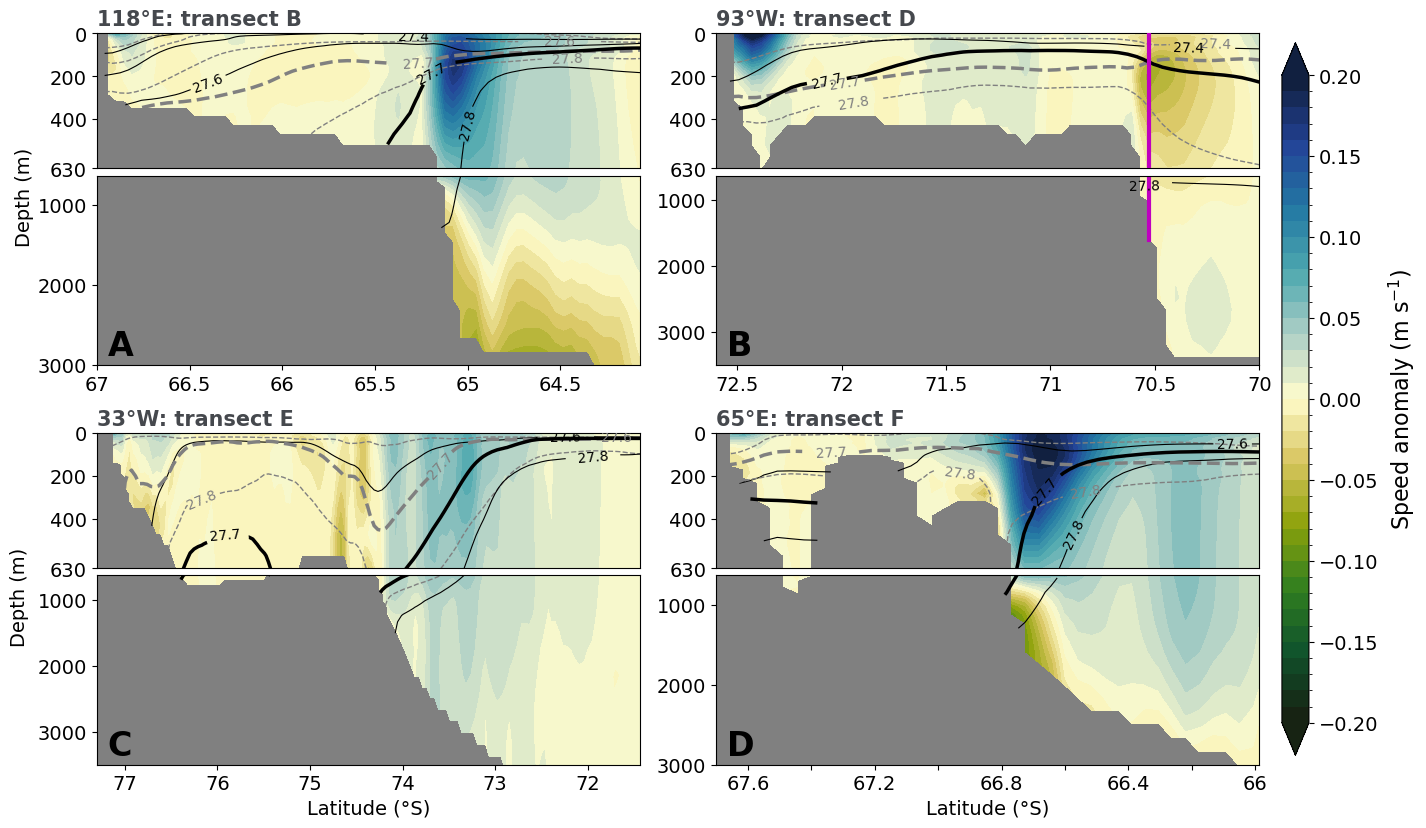

CPU times: user 2.84 s, sys: 418 ms, total: 3.26 s
Wall time: 2.77 s


In [16]:
%%time
lvls = [27.2, 27.4, 27.6, 27.9, 28.0, 28.2]
lvls_278 = [27.8]
lvls_bold = [27.7]

fig, axes = figure_setup()

for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('grey')

# plot speed anomaly and contours at Transect B
ds, cb = plot_speed_anomaly('b', zonal_lons[0], axes[0:2,0])
plot_density_contours(lvls, ds['sig0_ctrl'], [0, -100], -10, axes[0:2, 0], 'control', 1)
plot_density_contours(lvls_278, ds['sig0_ctrl'], [0, -100], -12, axes[0:2, 0], 'control', 1)
plot_density_contours(lvls, ds['sig0_expt'], [0, -100], -8, axes[0:2, 0], 'experiment', 0.8)
plot_density_contours(lvls_278, ds['sig0_expt'], [0, -100], 2, axes[0:2, 0], 'experiment', 0.8)
plot_density_contours_bold(lvls_bold, ds['sig0_ctrl'], [0, -100], -11, axes[0:2, 0], 'control', 2.5)
plot_density_contours_bold(lvls_bold, ds['sig0_expt'], [0, -100], -4, axes[0:2, 0], 'experiment', 2.5)
axes[0,0].set_xlim([-67, lat_n_lim[0]])
axes[1,0].set_xlim([-67, lat_n_lim[0]])
axes[1,0].set_xticklabels([67, '66.5', 66, '65.5', 65, '64.5'])
axes[0,0].set_yticks([630, 400, 200, 0])
axes[1,0].text(-0.15, 0.65, 'Depth (m)', rotation=90, transform=axes[1,0].transAxes)

# plot speed anomaly and contours at Transect D
ds, cb = plot_speed_anomaly('d', zonal_lons[1], axes[0:2,1])
axes[0,1].plot([ds.yu_ocean[250].values, ds.yu_ocean[250].values], [0, 630], lw=3, color='m', zorder=10)
axes[1,1].plot([ds.yu_ocean[250].values, ds.yu_ocean[250].values], [630, 1600], lw=3, color='m', zorder=1)

lvls = [27.4, 27.9, 28.0]
plot_density_contours(lvls, ds['sig0_ctrl'], [0, -215], -10, axes[0:2,1], 'control', 1)
plot_density_contours(lvls, ds['sig0_expt'], [0, -220], -10, axes[0:2,1], 'experiment', 0.8)
plot_density_contours(lvls_278, ds['sig0_ctrl'], [0, -220], -10, axes[0:2,1], 'control', 1)
plot_density_contours(lvls_278, ds['sig0_expt'], [0, -220], -10, axes[0:2,1], 'experiment', 0.8)
plot_density_contours_bold(lvls_bold, ds['sig0_ctrl'], [0, -230], -12, axes[0:2, 1], 'control', 2.5)
plot_density_contours_bold(lvls_bold, ds['sig0_expt'], [0, -100], -12, axes[0:2, 1], 'experiment', 2.5)

axes[0,1].set_xlim([-72.6, -70])
axes[1,1].set_xlim([-72.6, -70])
axes[1,1].set_ylim([3500, 630])
axes[0,1].set_yticks([630, 400, 200, 0])
axes[1,1].set_xticklabels(['', '72.5', 72, '71.5', 71, '70.5', 70])

# plot speed anomaly and contours at Transect E
ds, cb = plot_speed_anomaly('e', zonal_lons[2], axes[3:,0])

lvls = [27.6, 27.9, 28.0]
plot_density_contours(lvls, ds['sig0_ctrl'], [0, -260], -8, axes[3:,0], 'control', 1)
plot_density_contours(lvls, ds['sig0_expt'], [0, -280], -8, axes[3:,0], 'experiment', 0.8)
plot_density_contours(lvls_278, ds['sig0_ctrl'], [0, -240], -8, axes[3:, 0], 'control', 1)
plot_density_contours(lvls_278, ds['sig0_expt'], [0, -220], -8, axes[3:, 0], 'experiment', 0.8)
plot_density_contours_bold(lvls_bold, ds['sig0_ctrl'], [0, -280], -2, axes[3:, 0], 'control', 2.5)
plot_density_contours_bold(lvls_bold, ds['sig0_expt'], [0, -220], -6, axes[3:, 0], 'experiment', 2.5)

axes[-2,0].set_xlim([-77.3, lat_n_lim[3]])
axes[-1,0].set_xlim([-77.3, lat_n_lim[3]])
axes[-1,0].set_xticklabels(['', 77, 76, 75, 74, 73, 72])
axes[-2,0].set_yticks([630, 400, 200, 0])
axes[-1,0].set_ylim([3500, 630])
axes[-1,0].text(-0.16, 0.65, 'Depth (m)', rotation=90, transform=axes[-1,0].transAxes)

# plot speed anomaly and contours at Transect F
ds, cb = plot_speed_anomaly('f', zonal_lons[3], axes[3:,1])

lvls = [27.6]
plot_density_contours(lvls, ds['sig0_ctrl'], [315, -150], -11, axes[3:,1], 'control', 1)
plot_density_contours(lvls, ds['sig0_expt'], [315, -130], -14, axes[3:,1], 'experiment', 0.8)
plot_density_contours(lvls_278, ds['sig0_ctrl'], [315, -150], -10, axes[3:, 1], 'control', 1)
plot_density_contours(lvls_278, ds['sig0_expt'], [315, -140], 0, axes[3:, 1], 'experiment', 0.8)
plot_density_contours_bold(lvls_bold, ds['sig0_ctrl'], [0, -150], -13, axes[3:, 1], 'control', 2.5)
plot_density_contours_bold(lvls_bold, ds['sig0_expt'], [0, -140], 0, axes[3:, 1], 'experiment', 2.5)

axes[-2,1].set_xlim([-67.7, lat_n_lim[4]])
axes[-1,1].set_xlim([-67.7, lat_n_lim[4]])
axes[-1,1].set_xticklabels(['', 67.6, '', 67.2, '', 66.8, '', 66.4, '', 66])
axes[-2,1].set_yticks([630, 400, 200, 0])

# add colorbar
colorbar_vert(cb, [0.915, 0.12, 0.018, 0.75], 'Speed anomaly (m s$^{-1}$)')

# save to file
save_flag = 0
figfile = f'/home/561/hd4873/project3/figs/Fig10_ASC_transects.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()